In [1]:
import anndata
import scanpy as sc
import numpy as np
from sklearn.decomposition import PCA as pca
import argparse
import matplotlib.pyplot as plt
import pandas as pd



def read_data(data_path):
    return anndata.read_csv(data_path)

def preprocess_data(adata: anndata.AnnData, scale :bool=True):
    """Preprocessing dataset: filtering genes/cells, normalization and scaling."""
    sc.pp.filter_cells(adata, min_counts=5000)
    sc.pp.filter_cells(adata, min_genes=500)

    sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
    adata.raw = adata

    sc.pp.log1p(adata)
    if scale:
        sc.pp.scale(adata, max_value=10, zero_center=True)
        adata.X[np.isnan(adata.X)] = 0

    return adata


def PCA(X, num_components: int):
    return pca(num_components).fit_transform(X)

# def main():
data_path = 'data/scRNAseq_human_pancreas.csv'
heart = read_data(data_path)
heart = preprocess_data(heart)
X = PCA(heart.X, 100)
df = pd.DataFrame(X)
df.to_pickle('processed_data.pkl')

In [4]:
import pandas as pd
import anndata
import scanpy as sc
import numpy as np
from sklearn.decomposition import PCA as pca
import argparse
import matplotlib.pyplot as plt
from kmeans import KMeans
# Loading processed data
loaded_data = pd.read_pickle('processed_data.pkl')

knn = KMeans(3)
learnt_clustering, learnt_centroids = knn.fit(loaded_data.to_numpy())

old clustering empty at iteration 1, returning true
clustering changed, returning true
clustering changed, returning true
clustering changed, returning true
clustering changed, returning true
clustering changed, returning true
clustering changed, returning true
clustering changed, returning true
old clusterings = new clustering after 9 iterations, returning false


In [5]:
print(f'clustering 1: {learnt_clustering[0].size}')
print(f'clustering 2: {learnt_clustering[1].size}')
print(f'clustering 3: {learnt_clustering[2].size}')

print(f'centroids\n{learnt_centroids}')
print(f'clustering \n{learnt_clustering}')

clustering 1: 89700
clustering 2: 183300
clustering 3: 162900
centroids
[[-1.27505283e+01  3.67285800e+00 -3.69556069e+00  1.41775694e+01
  -4.29529762e+00 -8.45702946e-01 -3.13967824e+00 -1.89220119e+00
  -3.13604563e-01  1.31119752e+00  3.55076641e-01 -9.03872371e-01
  -2.23596752e-01  9.91307944e-02  7.68304706e-01  4.40004915e-02
  -1.29745588e-01  9.54997689e-02  2.61462301e-01 -3.69693696e-01
   2.81868547e-01 -1.11965209e-01 -4.45462205e-02  3.71678412e-01
   4.72499102e-01  3.91442589e-02 -3.16127270e-01 -1.13396309e-01
   2.07502302e-02 -6.43444583e-02  2.41067141e-01  1.75893798e-01
  -1.13879547e-01  5.31472340e-02  3.61207388e-02  1.45590752e-01
   9.45288762e-02 -3.50257978e-02 -5.34113944e-02 -7.75836185e-02
   9.77775455e-02 -2.96287518e-03  5.04077114e-02  1.23389862e-01
  -2.93172337e-02 -6.26637414e-02 -2.06659921e-02 -2.88331043e-02
  -1.65849533e-02  1.34088369e-02  7.44759589e-02 -2.20282357e-02
  -2.40287241e-02 -6.14925660e-02 -1.16863160e-03 -7.31820520e-03
  -4

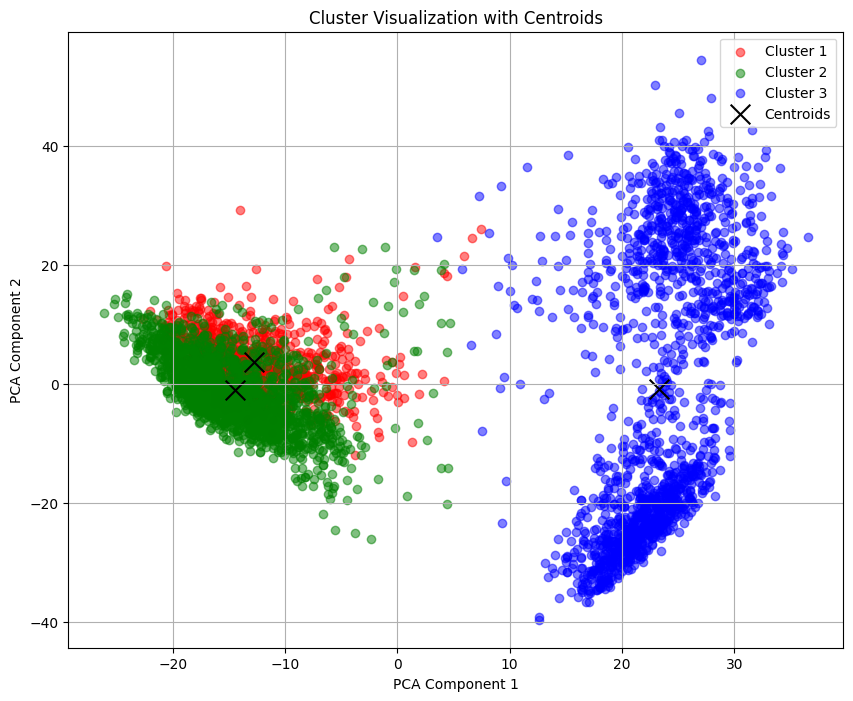

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Example data
clstrs = learnt_clustering  # Replace with your data
cntrds = learnt_centroids  # Replace with your centroids

# Combine clusters into a single array for PCA
all_points = np.vstack(clstrs)

# Perform PCA to reduce to 2D
pca = PCA(n_components=2)
reduced_points = pca.fit_transform(all_points)

# Plotting
plt.figure(figsize=(10, 8))

colors = ['r', 'g', 'b']
for i, cluster in enumerate(clstrs):
    cluster_reduced = pca.transform(cluster)  # Transform the cluster to 2D
    plt.scatter(cluster_reduced[:, 0], cluster_reduced[:, 1], color=colors[i], label=f'Cluster {i + 1}', alpha=0.5)

# Plot centroids
centroid_reduced = pca.transform(np.vstack(cntrds))
plt.scatter(centroid_reduced[:, 0], centroid_reduced[:, 1], color='k', marker='x', s=200, label='Centroids')

plt.title('Cluster Visualization with Centroids')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.grid()
plt.show()
